In [1]:
%matplotlib inline

import functools
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from itertools import chain
from data_tools.df_processing import char_combine_iter, add_curi
from data_tools.plotting import count_plot_h
from data_tools.wiki import execute_sparql_query, node_query_pipeline, standardize_nodes, standardize_edges

# New line recommended by notebook
from tqdm.autonotebook import tqdm 

/Users/sulhasan/opt/anaconda3/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def process_taxa(edges):
    nodes = edges.drop_duplicates(subset=['taxon', 'tax_id'])[['taxon', 'taxonLabel', 'tax_id']]
    nodes = add_curi(nodes, {'tax_id': 'NCBITaxon'})
    return standardize_nodes(nodes, 'taxon')

In [5]:
prev_dir = Path('../2_pipeline/01a_WikiData_Nodes/out/').resolve()
prev_nodes = pd.read_csv(prev_dir.joinpath('nodes.csv')) 

# Why do we need nodes to get edges? Is it a good idea that we have them?

In [6]:
nodes = []
edges = []

# Begin Queries


## Taxon Causes Disease (2 syntax, 2 approches)

Theyre are two syntax for taxon causes disease that exist in the WikiData data model:

1. Direct statements:  
    Taxon has-effect Disease... or Disease has-cause Taxon 


2. Qualifier Statements:  
    Disease has-cause infection (qual: of Taxon) 
    
There are also two approaches:

1. Direct links:      
    Taxon has-effect Disease


2. Punning down to a specific taxonomic level:  
    Partent_taxon has-effect Disease  
    Taxon has-parent* Parent_taxon  
    Taxon has-rank Species 

### Syntax 1: disease has-cause infection - qualifier: of TAXON

In [7]:
q = """    SELECT DISTINCT ?disease ?taxon ?taxonLabel ?tax_id
    WHERE 
    {
     {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.

     ?disease p:P828 [ps:P828 wd:Q166231;
                       pq:P642 ?taxon;].
      OPTIONAL{?taxon wdt:P685 ?tax_id}.
          
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }"""

In [8]:
qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes')

nodes.append(tax_nodes)
edges.append(edge_res)

edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q7331932,Q5459411,causes,crowd_sourced
1,Q9094469,Q55009678,causes,crowd_sourced
2,Q18822400,Q55009464,causes,crowd_sourced
3,Q1138287,Q18966421,causes,crowd_sourced
4,Q1111605,Q4735280,causes,crowd_sourced


In [9]:
tax_nodes.head()

,id,name,label,xrefs
0,Q1010102,Bunyaviridae,Taxon,
1,Q1026758,Caliciviridae,Taxon,NCBITaxon:11974
2,Q10457821,Conidiobolus coronatus,Taxon,NCBITaxon:34488
3,Q10462705,Cryptostroma corticale,Taxon,NCBITaxon:1463975
4,Q10584816,Microsporum distortum,Taxon,NCBITaxon:101202


### Syntax 2: disease has-cause TAXON or TAXON has-effect Disease

In [10]:
q = """    SELECT DISTINCT ?disease ?diseaseLabel ?doid ?taxon ?taxonLabel ?tax_id
    WHERE 
    {
       {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
      
        #?taxon wdt:P31 wd:Q16521.
        ?taxon wdt:P685 ?tax_id. 
      
       {?disease wdt:P828 ?taxon}UNION{?taxon wdt:P1542 ?disease}.
      
        OPTIONAL {?disease wdt:P699 ?doid.}
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }"""

In [11]:
q = """    SELECT DISTINCT ?disease ?diseaseLabel ?doid ?taxon ?taxonLabel ?tax_id
    WHERE 
    {
       {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
      
        #?taxon wdt:P31 wd:Q16521.
        ?taxon wdt:P685 ?tax_id. 
      
       {?disease wdt:P828 ?taxon}UNION{?taxon wdt:P1542 ?disease}.
      
        OPTIONAL {?disease wdt:P699 ?doid.}
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }"""

In [12]:
qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes')

nodes.append(tax_nodes)
edges.append(edge_res)

edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q131065,Q18554606,causes,crowd_sourced
1,Q131488,Q156103,causes,crowd_sourced
2,Q141837,Q842169,causes,crowd_sourced
3,Q140599,Q812671,causes,crowd_sourced
4,Q131271,Q180266,causes,crowd_sourced


In [13]:
tax_nodes.head(2)

,id,name,label,xrefs
0,Q1003460,Francisella tularensis,Taxon,NCBITaxon:263
1,Q103821065,Schistosoma mattheei,Taxon,NCBITaxon:31246


### Syntax 1, mode 2: disease has-cause infection - qualifier: of TAXON -> extend down parent taxa to SPECIES LEVEL

In [14]:
q = """    SELECT DISTINCT ?disease ?diseaseLabel ?doid ?parent_tax ?parent_taxLabel ?par_taxid ?taxon ?taxonLabel ?tax_id
    WHERE 
    {
      {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.

      
      ?disease p:P828 [ps:P828 wd:Q166231;
                       pq:P642 ?parent_tax;].
      OPTIONAL{?disease wdt:P699 ?doid}.
      OPTIONAL{?parent_tax wdt:P685 ?par_taxid}.
      
      # No kingdoms
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q36732}.
      # No Superphyla
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q3978005}.

      
      {?taxon wdt:P171+ ?parent_tax}UNION{?parent_tax wdt:P171+ ?taxon}
      ?taxon wdt:P105 wd:Q7432 .
      ?taxon wdt:P685 ?tax_id
          
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }"""

In [15]:
qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes', 'computed')
edge_res['comp_type'] = 'punning'

nodes.append(tax_nodes)
edges.append(edge_res)

edge_res.head()

,start_id,end_id,type,dsrc_type,comp_type
0,Q25840227,Q18975970,causes,computed,punning
1,Q25840232,Q18975970,causes,computed,punning
2,Q25840230,Q18975970,causes,computed,punning
3,Q25840261,Q18975970,causes,computed,punning
4,Q25840266,Q18975970,causes,computed,punning


In [16]:
tax_nodes.head()

,id,name,label,xrefs
0,Q1002578,Babesia divergens,Taxon,NCBITaxon:32595
1,Q100348282,Paramecium biaurelia,Taxon,NCBITaxon:65126
2,Q100348353,Ruhugu virus,Taxon,NCBITaxon:2652755
3,Q101135207,Acinetobacter portensis,Taxon,NCBITaxon:1839785
4,Q101135358,Acinetobacter guerrae,Taxon,NCBITaxon:1843371


### Syntax 2, mode 2: disease has-cause TAXON  or TAXON has-effct DISEASE -> extend down parent taxa to SPECIES LEVEL

In [17]:
q = """    SELECT DISTINCT ?disease ?diseaseLabel ?doid ?parent_tax ?parent_taxLabel ?parent_tax_id ?taxon ?taxonLabel ?tax_id
    WHERE 
    {
       {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
      
        #?tax wdt:P31 wd:Q16521.
        ?parent_tax wdt:P685 ?parent_tax_id. 
      
      # No kingdoms
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q36732}.
      # No Superphyla
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q3978005}.      
       {?disease wdt:P828 ?parent_tax}UNION{?parent_tax wdt:P1542 ?disease}.
      
        OPTIONAL {?disease wdt:P699 ?doid.}
      {?taxon wdt:P171+ ?parent_tax}UNION{?parent_tax wdt:P171+ ?taxon}
      ?taxon wdt:P685 ?tax_id .
      ?taxon wdt:P105 wd:Q7432 .
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
"""

In [18]:
qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes', 'computed')
edge_res['comp_type'] = 'punning'

nodes.append(tax_nodes)
edges.append(edge_res)

edge_res.head()

,start_id,end_id,type,dsrc_type,comp_type
0,Q30682861,Q12156,causes,computed,punning
1,Q7440141,Q98404923,causes,computed,punning
2,Q9362044,Q2443552,causes,computed,punning
3,Q12505794,Q12156,causes,computed,punning
4,Q6382438,Q327298,causes,computed,punning


In [19]:
tax_nodes.head()

,id,name,label,xrefs
0,Q1002578,Babesia divergens,Taxon,NCBITaxon:32595
1,Q100348353,Ruhugu virus,Taxon,NCBITaxon:2652755
2,Q101948759,Meteterakis formosensis,Taxon,NCBITaxon:1904904
3,Q101948899,Meteterakis occidentalis,Taxon,NCBITaxon:2283389
4,Q1024988,Cacao swollen-shoot virus,Taxon,NCBITaxon:31559


In [20]:
tax_nodes = pd.concat(nodes, sort=False, ignore_index=True).drop_duplicates(subset=['id'])
nodes = [tax_nodes]

## Go back and re-run taxon limited to protein and gene queries with each of the infectious taxa

In [21]:
len(tax_nodes)

14439

### This is too many to query

This is a very large number of Taxa to have to query for... However, WikiData may have far fewer taxa that actually have annotations to genes or proteins, so lets see how many of each are in WD.

In [22]:
q = """    SELECT DISTINCT ?taxon
    WHERE 
    {
      ?protein wdt:P31 wd:Q8054.
      ?protein wdt:P703 ?taxon.
    }"""

In [23]:
qr = execute_sparql_query(q)

In [24]:
prot_taxa = set(qr['taxon'])
len(prot_taxa)

401

This is already a managable number, but lets also check the genes, as they're separate queries...

In [25]:
q = """    SELECT DISTINCT ?taxon
    WHERE 
    {
      ?gene wdt:P31 wd:Q7187.
      ?gene wdt:P703 ?taxon.

    }"""

In [26]:
qr = execute_sparql_query(q)

In [27]:
gene_taxa = set(qr['taxon'])
len(gene_taxa)

213

Again, another manageable number, lets see how they overlap with what we've recieved for infectious taxa

In [28]:
len(prot_taxa & set(tax_nodes['id']))

71

Awesome, very queryable

In [29]:
len(gene_taxa & set(tax_nodes['id']))

35

Similarly querable

## Querying proteins of infectious taxa

In [30]:
q = """SELECT DISTINCT ?protein ?proteinLabel ?uniprot
        WHERE {{

          # Initial typing for Protein
          ?protein wdt:P31 wd:Q8054.
          ?protein wdt:P703 wd:{tax}.

          OPTIONAL{{?protein wdt:P352 ?uniprot .}}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}
        }}"""

In [31]:
tax_prot_edges = []

for tax_id in prot_taxa & set(tax_nodes['id']):
    this_q = q.format(tax=tax_id)
    res = node_query_pipeline(this_q, {'uniprot':'UniProt'}, 'protein')
    if res is None:
        continue
    
    nodes.append(res[['id', 'name', 'label', 'xrefs']].copy())
    
    res['tax'] = tax_id
    res_edges = standardize_edges(res, 'id', 'tax', 'in_taxon')
    tax_prot_edges.append(res_edges)

In [32]:
prot_tax = pd.concat(tax_prot_edges, sort=False, ignore_index=True)
edges.append(prot_tax)
prot_tax.head()

,start_id,end_id,type,dsrc_type
0,Q62311170,Q5956543,in_taxon,crowd_sourced
1,Q62311174,Q5956543,in_taxon,crowd_sourced
2,Q62311177,Q5956543,in_taxon,crowd_sourced
3,Q62311181,Q5956543,in_taxon,crowd_sourced
4,Q62311185,Q5956543,in_taxon,crowd_sourced


In [33]:
prot_tax['end_id'].nunique()

71

## Querying genes of infectious taxa

In [34]:
q = """SELECT DISTINCT ?gene ?geneLabel ?entrez ?symbol ?hgnc ?omim ?ensembl
        WHERE {{

          # Initial typing for Gene
          ?gene wdt:P31 wd:Q7187.
          ?gene wdt:P703 wd:{tax}.

          OPTIONAL{{?gene wdt:P351 ?entrez .}}
          OPTIONAL{{?gene wdt:P353 ?symbol .}}
          OPTIONAL{{?gene wdt:P354 ?hgnc .}}
          OPTIONAL{{?gene wdt:P492 ?omim .}}
          OPTIONAL{{?gene wdt:P594 ?ensembl .}}

          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}
        }}"""

In [35]:
tax_gene_edges = []
gene_curi_map = {'entrez': 'NCBIGene', 'symbol': 'SYM', 'hgnc':'HGNC', 'omim':'OMIM', 'ensembl':'ENSG'}

for tax_id in gene_taxa & set(tax_nodes['id']):
    this_q = q.format(tax=tax_id)
    
    res = node_query_pipeline(this_q, gene_curi_map, 'gene')
    if res is None:
        continue
    
    nodes.append(res[['id', 'name', 'label', 'xrefs']].copy())
    
    res['tax'] = tax_id
    res_edges = standardize_edges(res, 'id', 'tax', 'in_taxon')
    tax_gene_edges.append(res_edges)

In [36]:
gene_tax = pd.concat(tax_gene_edges, sort=False, ignore_index=True)
edges.append(gene_tax)
gene_tax.head()

,start_id,end_id,type,dsrc_type
0,Q62311172,Q5956543,in_taxon,crowd_sourced
1,Q62311175,Q5956543,in_taxon,crowd_sourced
2,Q62311179,Q5956543,in_taxon,crowd_sourced
3,Q62311183,Q5956543,in_taxon,crowd_sourced
4,Q62311187,Q5956543,in_taxon,crowd_sourced


In [37]:
gene_tax['end_id'].nunique()

35

## Gene ENCODES Protein

This edge will be used to map Genes to Proteins... our final network will likely not distinguish between the two, and therefore sources that only map to one (e.g. gene) will need this to map to the other (protein).

In [38]:
q = """SELECT DISTINCT ?gene ?protein 
WHERE {{

  # Initial typing for Gene
  ?gene wdt:P31 wd:Q7187.
  ?gene wdt:P703 wd:{tax}.
  # Initial typing for Protein
  ?protein wdt:P31 wd:Q8054.
  ?protein wdt:P703 wd:{tax}.
  
  {{?gene wdt:P688 ?protein}}UNION{{?protein wdt:P702 ?gene}}
}}"""

In [39]:
human_tax_id = 'Q15978631'

In [40]:
encodes_edges = []

infectious_tax = list(set(gene_tax['end_id']) & set(prot_tax['end_id']))

for tax in infectious_tax + [human_tax_id]:
    this_q = q.format(tax=tax)
    
    qr = execute_sparql_query(this_q)
    if qr is not None:
        this_edge = standardize_edges(qr, 'gene', 'protein', 'encodes')
        encodes_edges.append(this_edge)

In [41]:
encodes_edges = pd.concat(encodes_edges, sort=False, ignore_index=True)
edges.append(encodes_edges)
len(encodes_edges)

199879

# Protein MF Molecular Function

In [42]:
q = """SELECT DISTINCT ?protein ?molecular_function
WHERE {

  ?protein wdt:P31 wd:Q8054.
  ?molecular_function wdt:P686 ?goid.
  
  {?protein wdt:P680 ?molecular_function}
}"""

In [43]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'molecular_function', 'enables')

edges.append(edge_res)

In [44]:
edge_res.head(2)

,start_id,end_id,type,dsrc_type
0,Q21123681,Q14633877,enables,crowd_sourced
1,Q21125308,Q14633877,enables,crowd_sourced


# Protein BP Biological Process

In [45]:
q = """SELECT DISTINCT ?protein ?biological_process
WHERE {

  ?protein wdt:P31 wd:Q8054.
  ?biological_process wdt:P686 ?goid.
  
  {?protein wdt:P682 ?biological_process}
}"""

In [46]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'biological_process', 'involved_in')

edges.append(edge_res)

In [47]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q21096258,Q1057,involved_in,crowd_sourced
1,Q21096283,Q1057,involved_in,crowd_sourced
2,Q21096281,Q1057,involved_in,crowd_sourced
3,Q21096304,Q1057,involved_in,crowd_sourced
4,Q21096438,Q1057,involved_in,crowd_sourced


# Protein CC Cellular Component

In [48]:
q = """SELECT DISTINCT ?protein ?cell_component
WHERE {

  ?protein wdt:P31 wd:Q8054.
  ?cell_component wdt:P686 ?goid.
  
  {?protein wdt:P681 ?cell_component}
}"""

In [49]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'cell_component', 'part_of')

edges.append(edge_res)

In [50]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q416268,Q14762605,part_of,crowd_sourced
1,Q906904,Q14762605,part_of,crowd_sourced
2,Q1147372,Q14762605,part_of,crowd_sourced
3,Q1198053,Q14762605,part_of,crowd_sourced
4,Q2308016,Q14762605,part_of,crowd_sourced


# Compound TREATS Disease

In [51]:
q = """SELECT DISTINCT ?compound ?compoundLabel ?disease ?diseaseLabel
  WHERE {

    # Initial typing for Compound
    ?compound wdt:P31 wd:Q11173 .

    # Initial typing for Disease 
    # Either instance of Disease of has a Disease Ontology ID
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.

    {?compound wdt:P2175 ?disease}UNION{?disease wdt:P2176 ?compound}
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }

  }"""

In [52]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'disease', 'treats')

edges.append(edge_res)

In [53]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q169569,Q673083,treats,crowd_sourced
1,Q165399,Q201989,treats,crowd_sourced
2,Q165399,Q797668,treats,crowd_sourced
3,Q165399,Q3392853,treats,crowd_sourced
4,Q170304,Q1054718,treats,crowd_sourced


# Compound IW Protein

In [54]:
q = """SELECT DISTINCT ?compound ?compoundLabel ?qualifier ?qualifierLabel ?protein ?proteinLabel 
WHERE {

    # Initial typing for Compound
    ?compound wdt:P31 wd:Q11173 .

    # Initial typing for Protein
    ?protein wdt:P31 wd:Q8054 .

    { ?compound p:P129 [ps:P129 ?protein;
                  pq:P2868 ?qualifier] }
    UNION { ?protein p:P129 [ps:P129 ?compound;
                 pq:P366 ?qualifier] }

    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}"""

In [55]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'protein', 'qualifierLabel')

edges.append(edge_res)

In [56]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q773449,Q7799751,agonist,crowd_sourced
1,Q167934,Q21109363,agonist,crowd_sourced
2,Q167934,Q21115046,agonist,crowd_sourced
3,Q186242,Q21498865,agonist,crowd_sourced
4,Q5977854,Q21988427,agonist,crowd_sourced


## Anatomy SITE OF Disease

In [57]:
q = """SELECT DISTINCT ?disease ?diseaseLabel ?anatomy ?anatomyLabel 
WHERE {

    # Initial typing for Disease
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    {?disease1 wdt:P31 wd:Q12136}UNION{?disease1 wdt:P699 ?doid1}.

    # Initial typing for Anatomical Structure
    ?anatomy wdt:P1554 ?uberon .

    {?disease1 wdt:P927 ?anatomy} {?disease wdt:P279? ?disease1}

    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}"""

In [58]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'anatomy', 'disease', 'site_of')

edges.append(edge_res)

In [59]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q48228,Q3726816,site_of,crowd_sourced
1,Q2640512,Q2165663,site_of,crowd_sourced
2,Q1543208,Q2213687,site_of,crowd_sourced
3,Q9618,Q2267451,site_of,crowd_sourced
4,Q9404,Q3508804,site_of,crowd_sourced


## Gene AW Disease

In [60]:
q = """SELECT DISTINCT ?disease ?diseaseLabel ?gene ?geneLabel 
WHERE {

    # Initial typing for Disease
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
  
    # Initial typing for Gene
    ?gene wdt:P31 wd:Q7187 .

    ?disease wdt:P2293 ?gene

    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}"""

In [61]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'gene', 'disease', 'associated_with')

edges.append(edge_res)

In [62]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q5191429,Q27674873,associated_with,crowd_sourced
1,Q5009814,Q11081,associated_with,crowd_sourced
2,Q4654809,Q844935,associated_with,crowd_sourced
3,Q5145886,Q55781450,associated_with,crowd_sourced
4,Q4039195,Q181923,associated_with,crowd_sourced


# Pathway HP Gene

In [63]:
q = """SELECT DISTINCT ?pathway ?gene 
WHERE {

    # Initial typing for Pathway
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
  
    # Initial typing for Gene
    ?gene wdt:P31 wd:Q7187 .

    ?pathway wdt:P527 ?gene
} """

In [64]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'gene', 'has_part')

edges.append(edge_res)

In [65]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q30225529,Q4652205,has_part,crowd_sourced
1,Q30225529,Q5005962,has_part,crowd_sourced
2,Q30225528,Q5469819,has_part,crowd_sourced
3,Q30225529,Q5513945,has_part,crowd_sourced
4,Q30225529,Q8041711,has_part,crowd_sourced


## Pathway Has Part Compound

In [66]:
q = """SELECT DISTINCT ?pathway ?compound 
WHERE {

    # Initial typing for Pathway
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
  
    # Initial typing for Compound
    ?compound wdt:P31 wd:Q11173 .

    ?pathway wdt:P527 ?compound
} """

In [67]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'compound', 'has_part')

edges.append(edge_res)

In [68]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q30225529,Q210041,has_part,crowd_sourced
1,Q28031254,Q283,has_part,crowd_sourced
2,Q28031254,Q28746,has_part,crowd_sourced
3,Q28031254,Q213050,has_part,crowd_sourced
4,Q28031228,Q26992303,has_part,crowd_sourced


## Pathway Medical_condition Disease

In [69]:
q = """SELECT DISTINCT ?pathway ?disease 
WHERE {

    # Initial typing for Pathway
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
  
    # Initial typing for Disease
    {?disease wdt:P31 wd:Q12136 .}UNION{?disease wdt:P699 ?doid}

    {?pathway wdt:P1050 ?disease}
} """

In [70]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'disease', 'associated_with')

edges.append(edge_res)

In [71]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q29892275,Q9303627,associated_with,crowd_sourced
1,Q28922670,Q12078,associated_with,crowd_sourced
2,Q29883346,Q12078,associated_with,crowd_sourced
3,Q29883419,Q11085,associated_with,crowd_sourced
4,Q29883401,Q12078,associated_with,crowd_sourced


## Pathway to BP

In [72]:
q = """SELECT DISTINCT ?pathway ?bio_process 
WHERE {

    # Initial typing for Pathway
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
  
    # Initial typing for Bio Process
    ?bio_process wdt:P31 wd:Q2996394 .
    ?bio_process wdt:P686 ?goid .

    {?pathway wdt:P31 ?bio_process}UNION{?bio_process wdt:P31 ?pathway}
} """

In [73]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'bio_process', 'involved_in')

edges.append(edge_res)

In [74]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q100235139,Q184726,involved_in,crowd_sourced
1,Q99594865,Q21126889,involved_in,crowd_sourced
2,Q100235742,Q14330653,involved_in,crowd_sourced
3,Q100235740,Q14330653,involved_in,crowd_sourced
4,Q100235741,Q14330653,involved_in,crowd_sourced


## Disease to Phenotype

In [75]:
q = """  SELECT DISTINCT ?disease ?pheno
  WHERE {

      # Initial typing for Symptom
      {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}
    
      # Initial typing for Phenotype
      {?pheno wdt:P31 wd:Q169872.}UNION{?pheno wdt:P3841 ?hpo}

      {?pheno wdt:P780 ?disease}UNION{?disease wdt:P780 ?pheno}

  }"""

In [76]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'disease', 'pheno', 'presents')

edges.append(edge_res)

In [77]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q408089,Q223907,presents,crowd_sourced
1,Q9303627,Q223907,presents,crowd_sourced
2,Q53951449,Q223907,presents,crowd_sourced
3,Q83319,Q9690,presents,crowd_sourced
4,Q131755,Q9690,presents,crowd_sourced


## Compound TREATS Phenotype

In [78]:
q = """SELECT DISTINCT ?compound ?pheno
  WHERE {

      # Initial typing for Compound
      ?compound wdt:P31 wd:Q11173 .
    
      # Initial typing for Phenotype
      {?pheno wdt:P31 wd:Q169872.}UNION{?pheno wdt:P3841 ?hpo}

      {?pheno wdt:P2176 ?compound}UNION{?compound wdt:P2175 ?pheno}
  } """

In [79]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'pheno', 'treats')

edges.append(edge_res)

In [80]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q416331,Q1097957,treats,crowd_sourced
1,Q425867,Q1097957,treats,crowd_sourced
2,Q1147309,Q1097957,treats,crowd_sourced
3,Q18936,Q504775,treats,crowd_sourced
4,Q238474,Q422225,treats,crowd_sourced


# Subclass Edges for later Punning

## Disease is a Subclass of disease

In [81]:
q = """SELECT DISTINCT ?disease ?diseaseLabel ?disease1 ?disease1Label
WHERE {

    # Initial typing for Disease
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    {?disease1 wdt:P31 wd:Q12136}UNION{?disease1 wdt:P699 ?doid1}.

    ?disease wdt:P279? ?disease1

    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}"""

In [82]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'disease', 'disease1', 'subclass_of')

edges.append(edge_res)

In [83]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q145790,Q145790,subclass_of,crowd_sourced
1,Q147270,Q147270,subclass_of,crowd_sourced
2,Q157008,Q157008,subclass_of,crowd_sourced
3,Q160649,Q160649,subclass_of,crowd_sourced
4,Q132971,Q132971,subclass_of,crowd_sourced


## Anatomy subclass of Anatomy

In [84]:
q = """SELECT DISTINCT ?anatomy ?anatomyLabel ?anatomy1 ?anatomy1Label
WHERE {


    # Initial typing for Anatomical Structure
    ?anatomy wdt:P1554 ?uberon .
    ?anatomy1 wdt:P1554 ?uberon1 .
    
    ?anatomy wdt:P279? ?anatomy1

    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}"""

In [85]:
qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'anatomy', 'anatomy1', 'subclass_of')

edges.append(edge_res)

In [86]:
edge_res.head()

,start_id,end_id,type,dsrc_type
0,Q155925,Q155925,subclass_of,crowd_sourced
1,Q143652,Q143652,subclass_of,crowd_sourced
2,Q133105,Q133105,subclass_of,crowd_sourced
3,Q168291,Q168291,subclass_of,crowd_sourced
4,Q83379,Q83379,subclass_of,crowd_sourced


## Combine new edge and node results

In [87]:
nodes.append(prev_nodes)
nodes = pd.concat(nodes, sort=False, ignore_index=True)
edges = pd.concat(edges, sort=False, ignore_index=True)

In [88]:
len(nodes)

605217

In [89]:
len(edges)

3878511

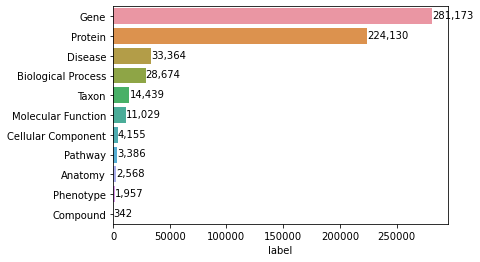

In [90]:
count_plot_h(nodes['label'])

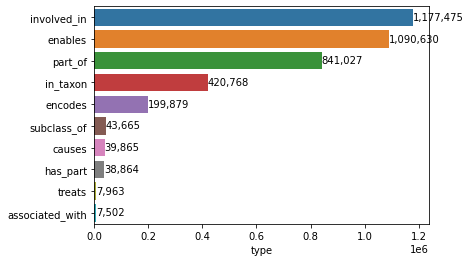

In [91]:
count_plot_h(edges['type'].value_counts().head(10))

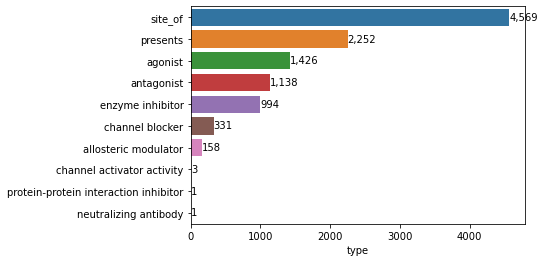

In [92]:
count_plot_h(edges['type'].value_counts().head(20).tail(10))

# Save the new info out

In [93]:
this_file = '01b_WikiData_Edges'
out_dir = Path('../2_pipeline/').joinpath(this_file, 'out').resolve()

out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
edges.to_csv(out_dir.joinpath('edges.csv'), index=False)